# Setup

In [1]:
#!pip install --user music21 pygame iteration_utilities

## Configure Music21

The library uses your installation of [MuseScore](https://musescore.org/) to display scores. Tell it where the MuseScore executable can be found on your computer by uncommenting and adapting the respective line. This needs to happen only once.

In [2]:
from music21 import environment
# Windows (adapt Program Files)
#musescore_executable = r'C:\Program Files (x86)\MuseScore 3\bin\MuseScore3.exe'
musescore_executable = r'C:\Program Files\MuseScore 3\bin\MuseScore3.exe'

# Mac path
#musescore_executable = '/Applications/MuseScore 3.app/Contents/MacOS/mscore'

# Linux path (if Package manager is not Snap)
#musescore_executable = '/usr/bin/mscore'
# otherwise, download AppImage, e.g.
#musescore_executable = '~/Downloads/MuseScore-3.6.2.548021370-x86_64.AppImage'

environment.set('musescoreDirectPNGPath', musescore_executable)
environment.set('musicxmlPath', musescore_executable)
environment.set('autoDownload', 'allow')

# Preliminaries

In [1]:
from fractions import Fraction
from music21 import midi, note, stream, instrument, meter

## Helper functions

In this tutorial, we use the library `music21` to visualize rhythms in score format. Music21 stores `Note` objects into containers called `Stream` (or its subclass `Measure`). The parameters of the note objects (e.g., duration, onset, and pitch) can be transformed algorithmically, and the containers can then be visualized in score format or rendered as audio playback in midi format.

First, here is a shortcut for **playback**:

In [2]:
def play(score):
    """Takes a Measure or Stream and plays it back."""
    midi.realtime.StreamPlayer(score).play()

**Now, we define a function to create individual percussion sounds with a given duration.**

We express durations in whole-note units, so that quarter-notes have duration 1/4, eigth-notes have duration 1/8 etc.

Since we are dealing with rhythm, we don't really care about the pitch of the notes, so we assign a default value (C4).

In [3]:
def percussion_hit(duration, pitch = "C4"):
    """Create Note object for percussion hits (default pitch is C4)

    Parameters
    ----------
    duration : float or Fraction
        Duration of the event.
    pitch : str, optional
        Matters only for display.

    Returns
    -------
    music21.note.Note
        A Note object that can be embedded in containers such as Chords, Measures, Streams
    """
    return note.Note(pitch, quarterLength = duration*4)

So, a percussion_hit of duration 1 (whole-note) spans 4 quarter-notes:

In [4]:
whole_note = percussion_hit(1)
whole_note.quarterLength

4.0

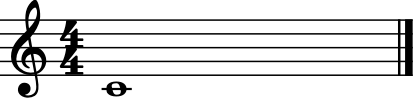

In [5]:
whole_note.show()

**Now, we create a container object (a Stream or a Measure) for our percussion_hits.**

In [6]:
def create_percussion(time_sig = None):
    """ Creates a container with or without time signature to which
    events can be appended.

    Parameters
    ----------
    time_sig : str, optional
        By default, no time signature is specified, so that a single measure of unspecified capacity is generated.
        If you do specify a time signature a stream with the given time signature is created instead.

    Returns
    -------
    music21.stream.Stream
        If time_sig is None, the return value is a Measure which is a subclass of Stream.
    """
    if time_sig == None:
        drumPart = stream.Measure()
    else:
        drumPart = stream.Stream()
        drumPart.timeSignature = meter.TimeSignature(time_sig)
    
    drumPart.insert(0, instrument.Woodblock()) #assign woodblock timbre
    return drumPart

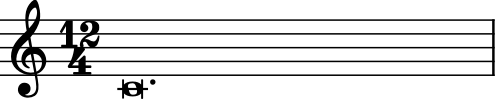

In [7]:
no_timesig = create_percussion()     # create stream without time signature
no_timesig.append(percussion_hit(3)) # add an event of length 3 whole notes
no_timesig.show()                    # display

In [8]:
play(no_timesig) # play back

pygame 2.1.2 (SDL 2.0.18, Python 3.10.0)
Hello from the pygame community. https://www.pygame.org/contribute.html


**We can now create rhythms by appending percussion_hits to a stream.**

To simplify the process, we define new function that appends a percussion_hit of given duration to an existing percussion stream:

In [9]:
def append_event(duration, stream_object, rest = False, pitch ='C4'):
    """ Appends a rest or percussion_hit of the given duration to an existing stream.

    Parameters
    ----------
    duration : float or Fraction
        Duration of the new event.
    stream_object : music21.stream.Stream
        Stream object to which append the new event to.
    rest : bool, optional
        By default, the appended event has the pitch ``pitch``.
        Pass True to append a rest instead.
    pitch : str, optional
        Pitch of the appended event, matters only for display. Disregarded if ``rest`` is True.

    Returns
    -------
    None
    """
    if rest:
        stream_object.append(note.Rest(quarterLength = duration*4))
    else:
        stream_object.append(percussion_hit(duration, pitch))

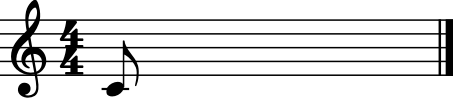

In [10]:
four_four = create_percussion("4/4")
append_event(1/8, four_four)
four_four.show()

Finally, bundle everything so we can create a rhythm directly from a list of durations:

In [11]:
def rhythm_from_sequence(durations, time_sig = None, pitch = 'C4', rhythm=None):
    """ Generate rhythmic stream from a list of durations. Rests are indicated by specifying a duration as a string.

    Parameters
    ----------
    durations : list of {float, Fraction, str}
        Sequence of durations. Floats or Fractions passed as strings are interpreted as rests.
    time_sig : str, optional
        By default, no time signature is specified, so that a single measure of unspecified capacity is generated.
        If you do specify a time signature a stream with the given time signature is created instead.
    pitch : str, optional
        Matters only for display.
    rhythm : music21.stream.Stream, optional
        If you want to append the rhythm to an existing Stream, pass this Stream. Otherwise a new one will be created.

    Returns
    -------
    music21.stream.Stream
        The rhythm reflecting the given list of durations.
    """
    if rhythm is None:
        rhythm = create_percussion(time_sig = time_sig)
    for dur in durations:
        is_rest = False
        if dur not in (0, '0'):
            if isinstance(dur, str):
                is_rest = True
                dur = Fraction(dur)
            append_event(dur, rhythm, rest = is_rest, pitch = pitch)
    return rhythm

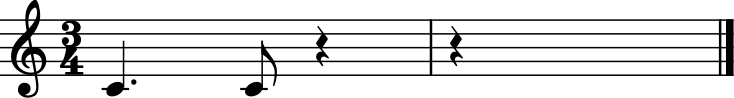

In [12]:
rhythm = rhythm_from_sequence([3/8, 1/8, '1/2'], time_sig='3/4')
rhythm.show()

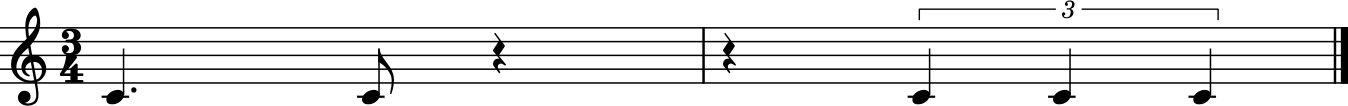

In [13]:
rhythm = rhythm_from_sequence([1/6]*3, time_sig='3/4', rhythm=rhythm)
rhythm.show()

# A context-free grammar of rhythms

In a Markov model, each rhythmic event depends on the preceding one(s). A different approach to modelling rhythm is to interpret rhythmic events as recursive elaborations of a latent rhythmic structure. The following example of hierarchical rhythm generation is based on the context-free rhythm grammar from [Rohrmeier (2020)](https://program.ismir2020.net/poster_4-20.html).



## Categories
First, in this formalism, a rhythmic category is a 3-ple of parameters defining a time-span: the upbeat, the body and the tail. The body represents the "ideal" duration of the timespan, if no extensions or timestealing happen. The upbeat encodes the addition (if positive) or subtraction (if negative) of a portion at the beginning of the timespan. Similarly, the coda encodes the addition (if positive) or subtraction (if negative) of a portion at the end of the timespan. As a consequence, the overall duration of a timespan (a, b, c) is a+b+c.

Each rhythmic category can generate other rhythmic categories by means of the application of a rule.

In [14]:
class Category:
    def __init__(self, upbeat, body, tail, is_terminal=False):
        #Parameters
        self.upbeat = upbeat
        self.body = body
        self.tail = tail
        self.is_terminal = is_terminal
        self.parameters = (upbeat, body, tail)

    def __repr__(self):
        """Display the category as a list if terminal, otherwise as tuple."""
        if self.is_terminal:
            return str(list(self.parameters))
        return str(self.parameters)

    @property
    def durations(self):
        durations = [self.upbeat, self.body + self.tail]
        if self.upbeat < 0:
            durations[0] = 0
            durations[1] += self.upbeat
        return durations

    def show(self):
        """A helper function to display the rhythmic category. Shows a positive upbeat separately from the body+tail"""
        return rhythm_from_sequence(self.durations).show()

For example, here is a rhythmic category:

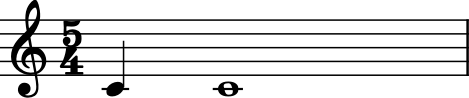

In [15]:
example_category = Category(1/4, 1, 0)
example_category.show()

## Rules

**Freeze.** Unary rule, implementation detail. Since non-terminals and terminals look the same, we distinguish between them using their boolean property `is_terminal`. The function `freeze()` takes a non-terminal and returns a copy with `is_terminal` set to True.

In [16]:
def freeze(parent):
    """Turn non-terminal into terminal."""
    assert not parent.is_terminal, "Trying to apply freeze to a terminal."
    result = Category(*parent.parameters, is_terminal=True)
    return (result, )

**Split**. This rule splits a rhythmic category into two "children" by dividing the body into two parts. The left child inherits the upbeat of the parent category, while the right child inherits the coda of the parent category. Finally, the right child might "steal" a portion from the left child (if the right child has a positive upbeat), or vice-versa (if the right child has a negative upbeat). The split rule comes with two parameters. First, the split ratio (which is often 1/2, representing an equal split). The second parameter is optional, and specifies the upbeat of the right child (default is 0).

In [17]:
def split(parent, ratio = 1/2, right_child_upbeat=0, display=False):
    """SPLIT operation on parent category.

    Parameters
    ----------
    parent : Category
    ratio : float or Fraction
        Multiply the parent's body with ratio to get the left child's body.
    right_child_upbeat : float or Fraction
        The left child's upbeat is inherited from the parent, the right child's
        upbeat can be specified here, resulting in the left child getting a negative
        tail of the same size.

    Returns
    -------
    pair of Category

    """
    assert not parent.is_terminal, "Trying to apply split to a terminal."
    left_child_body = parent.body * ratio
    right_child_body = parent.body - left_child_body
    left_child_cat = Category(parent.upbeat, left_child_body, - right_child_upbeat)
    right_child_cat = Category(right_child_upbeat, right_child_body, parent.tail)
    result = (left_child_cat, right_child_cat)
    if display:
        print(f"{parent} => {result}")
    return result

In [18]:
split(example_category, display=True)

(0.25, 1, 0) => ((0.25, 0.5, 0), (0, 0.5, 0))


((0.25, 0.5, 0), (0, 0.5, 0))

Note that this is an equal split where the children do not steal time from each other. Here we have a different split, where the right child has an upbeat, hence stealing time from the left child:

In [19]:
split(example_category, 1/2, 1/16, display=True)

(0.25, 1, 0) => ((0.25, 0.5, -0.0625), (0.0625, 0.5, 0))


((0.25, 0.5, -0.0625), (0.0625, 0.5, 0))

**Prepare**. This rule separates the upbeat (if it is positive) from the body, creating two distinct rhytmic categories: one inherits the parent's upbeat as its own body, the other inherits the parent's body and tail (but has not upbeat).

In [20]:
def prepare(parent, display=False):
    """UPBEAT rule: separates upbeat from body"""
    assert not parent.is_terminal, "Trying to apply prepare to a terminal."
    assert parent.upbeat > 0, f"Trying to apply prepare to a category with upbeat {parent.upbeat}."
    left_child_cat = Category(0, parent.upbeat, 0)
    right_child_cat = Category(0, parent.body, parent.tail)
    result = (left_child_cat,  right_child_cat)
    if display:
        print(f"{parent} => {result}")
    return result

In [21]:
prepare(example_category, display=True)

(0.25, 1, 0) => ((0, 0.25, 0), (0, 1, 0))


((0, 0.25, 0), (0, 1, 0))

**Anticipate and Delay**: these two rules are unary rules, i.e. the parent is simply transformed into one different category. In the anticipation (or e-shift) rule, the upbeat is absorbed into the body, so that the body of the timespan is shifted to the left. The delay (or l-shift) rule does the opposite.

Here is, for example, an application of the anticipation rule. Since this is a unary rule, only one child is generated:

In [22]:
def shift(parent, to_left=True, display=False):
    """ Shift body to the left (anticipate) or the right (delay).

    Parameters
    ----------
    parent : Category
    to_left : bool, optional
        By default, the anticipate rule is applied (e-shift).
        Pass False to apply delay (l-shift).

    Returns
    -------
    tuple of Category
    """
    assert not parent.is_terminal, "Trying to apply shift to a terminal."
    if to_left:
        result = Category(0, parent.body, parent.upbeat+parent.tail)
    else:
        result = Category(parent.upbeat + self.tail, self.body, 0)
    if display:
        print(f"{parent} => {result}")
    return (result, )

In [23]:
shift(example_category, display=True)

(0.25, 1, 0) => (0, 1, 0.25)


((0, 1, 0.25),)

## Generation

In [24]:
class Tree:

    def __init__(self, root_category):
        self.root = root_category
        self.left, self.right = None, None # Tree objects

    @property
    def is_frozen(self):
        if self.root.is_terminal:
            return True
        if self.left is None:
            return False
        if self.left.is_frozen:
            if self.right is None:
                return True
            return self.right.is_frozen
        return False

    @property
    def leaves(self):
        assert self.is_frozen, "Tree is not a complete derivation, some leaves are non-terminals."
        if self.root.is_terminal:
            return [d for d in self.root.durations if d > 0]
        result = self.left.leaves
        if self.right is not None:
            result.extend(self.right.leaves)
        return result

    def get_leftmost(self):
        if self.root.is_terminal:
            print("Tree is frozen.")
            return
        if self.left is None:
            return self
        if not self.left.is_frozen:
            return self.left.get_leftmost()
        if self.right is not None and not self.right.is_frozen:
            return self.right.get_leftmost()

    def apply(self, rules):
        """ Applies the rules in sequence, each to the leftmost non-terminal.

        Parameters
        ----------
        rules : list of (callable, dict)
            For each rule to apply, pass a pair containing the function and a dictionary with the function parameters.

        Returns
        -------
        None
        """
        if isinstance(rules, tuple):
            rules = [rules]
        for i, (func, params) in enumerate(rules):
            leftmost_tree = self.get_leftmost()
            if leftmost_tree is None:
                print(f"Could only apply {i} out of {len(rules)} rules because derivation was complete at that point.")
                break
            category = leftmost_tree.root
            result = func(category, **params)
            leftmost_tree.left = Tree(result[0])
            if len(result) == 2:
                leftmost_tree.right = Tree(result[1])

    def freeze_all(self):
        """Apply the function freeze() to all non-terminals, turning them into terminals."""
        leftmost_tree = self.get_leftmost()
        while leftmost_tree is not None:
            leftmost_tree.apply((freeze, {}))
            leftmost_tree = self.get_leftmost()

    def show(self, playback=False, *args, **kwargs):
        """Freezes all open terminals and shows the generated rhythm as a score."""
        self.freeze_all()
        durations = self.leaves
        stream = rhythm_from_sequence(durations, *args, **kwargs)
        if playback:
            play(stream)
        stream.show()

    def __repr__(self):
        if self.left is not None and self.left.root.is_terminal:
            return str(self.left.root)
        result = str(self.root)
        if self.left is not None:
            result += " [" + self.left.__repr__()
            if self.right is not None:
                result += self.right.__repr__()
            result += "] "
        return result

In [25]:
t = Tree(Category(1/4, 4, 0))
t.apply((split, {}))
print(f"is_frozen: {t.is_frozen}")
t

is_frozen: False


(0.25, 4, 0) [(0.25, 2.0, 0)(0, 2.0, 0)] 

In [26]:
t.get_leftmost()

(0.25, 2.0, 0)

In [27]:
t.apply((freeze, {}))
print(f"is_frozen: {t.is_frozen}")
t

is_frozen: False


(0.25, 4, 0) [[0.25, 2.0, 0](0, 2.0, 0)] 

In [28]:
t.get_leftmost()

(0, 2.0, 0)

In [29]:
t.apply((freeze, {}))
print(f"is_frozen: {t.is_frozen}")
t

is_frozen: True


(0.25, 4, 0) [[0.25, 2.0, 0][0, 2.0, 0]] 

In [30]:
t.get_leftmost()

Leaves as durations: [0.25, 2.0, 2.0]


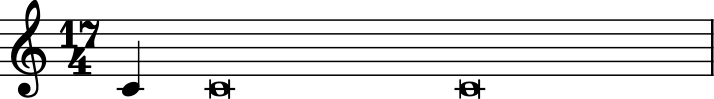

In [31]:
print(f"Leaves as durations: {t.leaves}")
rhythm_from_sequence(t.leaves).show()

Here, as an example, we generate the initial rhythm from the [Jazz standard "Blue Bossa"](https://youtu.be/U7eOs5lERww?t=12) (Rohrmeier 2020)

<img src="img/BlueBossa.png">

The rhythm lasts 4 bars (in 4/4 meter) plus a 1/4 upbeat, so that the root category is:

In [32]:
root = Category(1/4, 4, 0)

<img src="img/bb01.png">

The recipe to generate a rhythm can be represented in the form of a derivation tree. Each node of the tree is occupied by a rhythmic category, and the branches originating at a node lead to the children of that node under some rule application. A full derivation tree for the example from Blue Bossa is the following: 

<img src="img/HierarchicalRhythm.png">

Let us start from the top of the tree, where we find the root category. The first branching is a split rule (the body is split in half), leading to two children nodes. We can represent a node of the tree as a list, containing the rule applied at that node (if any), as well as its children nodes. In the case of the topmost node in the above tree, the rule is a split with ratio 1/2 and right-child's head 1/4.

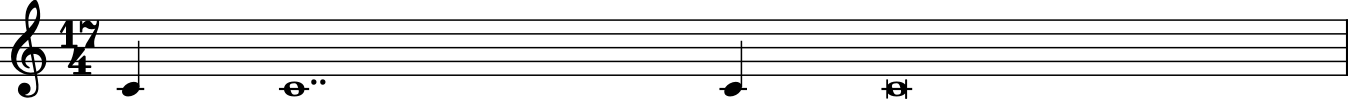

In [33]:
tree = Tree(root)
tree.apply((split, dict(ratio=1/2, right_child_upbeat=1/4)))
tree.show()

<img src="img/bb02.png">

Let's look now at the left child of the root node. Here, another split rule is applied, resulting in two children with equal body (split factor 1/2) and a 1/8 upbeat for the right child. 

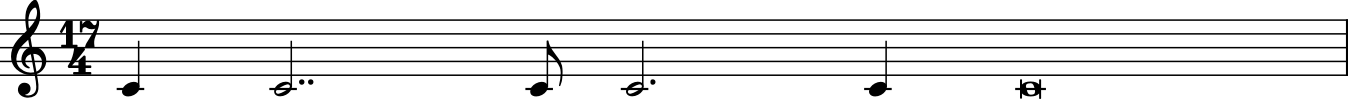

In [34]:
tree = Tree(root)
tree.apply([(split, dict(ratio=1/2, right_child_upbeat=1/4)),
            (split, dict(ratio=1/2, right_child_upbeat=1/8))
           ])
tree.show()

<img src="img/bb03.png">

The left child of the left child of the root also undergoes a split operation...

(0.25, 4, 0) [(0.25, 2.0, -0.25) [(0.25, 1.0, -0.125) [(0.25, 0.5, -0.125)(0.125, 0.5, -0.125)] (0.125, 1.0, -0.25)] (0.25, 2.0, 0)] 


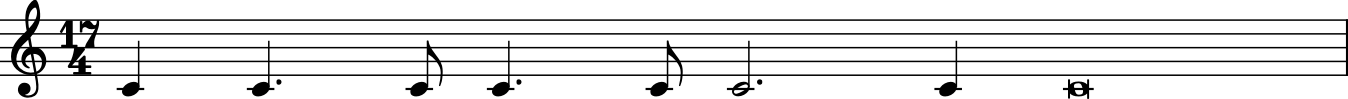

In [35]:
tree = Tree(root)
tree.apply([(split, dict(ratio=1/2, right_child_upbeat=1/4)),
            (split, dict(ratio=1/2, right_child_upbeat=1/8)),
            (split, dict(ratio=1/2, right_child_upbeat=1/8))
           ])
print(tree)
tree.show()

<img src="img/bb04.png">

... while its own left child (i.e., of the left child of the left child of the root) undergoes a preparation rule...

(0.25, 4, 0) [(0.25, 2.0, -0.25) [(0.25, 1.0, -0.125) [(0.25, 0.5, -0.125) [[0, 0.25, 0][0, 0.5, -0.125]] (0.125, 0.5, -0.125)] (0.125, 1.0, -0.25)] (0.25, 2.0, 0)] 


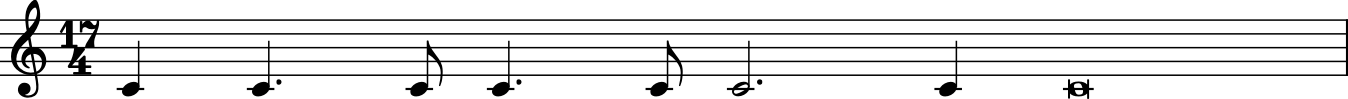

In [36]:
tree = Tree(root)
tree.apply([(split, dict(ratio=1/2, right_child_upbeat=1/4)),
            (split, dict(ratio=1/2, right_child_upbeat=1/8)),
            (split, dict(ratio=1/2, right_child_upbeat=1/8)),
            (prepare, {}),
            (freeze, {}),
            (freeze, {}),
           ])
print(tree)
tree.show()

... similarly to the right child of the left child of the left child of the root:

(0.25, 4, 0) [(0.25, 2.0, -0.25) [(0.25, 1.0, -0.125) [(0.25, 0.5, -0.125) [[0, 0.25, 0][0, 0.5, -0.125]] (0.125, 0.5, -0.125) [(0, 0.125, 0)(0, 0.5, -0.125)] ] (0.125, 1.0, -0.25)] (0.25, 2.0, 0)] 


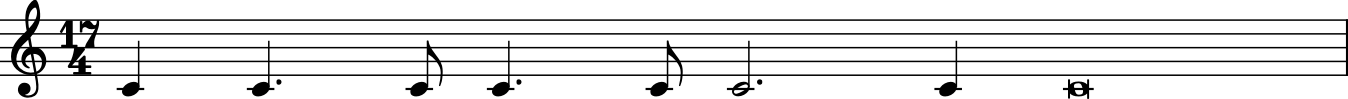

In [37]:
tree = Tree(root)
tree.apply([(split, dict(ratio=1/2, right_child_upbeat=1/4)),
            (split, dict(ratio=1/2, right_child_upbeat=1/8)),
            (split, dict(ratio=1/2, right_child_upbeat=1/8)),
            (prepare, {}),
            (freeze, {}),
            (freeze, {}),
            (prepare, {}),
           ])
print(tree)
tree.show()

The right child of this preparation rule is further elaborated with a split, whose right child is then anticipated:

(0.25, 4, 0) [(0.25, 2.0, -0.25) [(0.25, 1.0, -0.125) [(0.25, 0.5, -0.125) [[0, 0.25, 0][0, 0.5, -0.125]] (0.125, 0.5, -0.125) [[0, 0.125, 0](0, 0.5, -0.125) [[0, 0.25, -0.125](0.125, 0.25, -0.125) [(0, 0.25, 0.0)] ] ] ] (0.125, 1.0, -0.25)] (0.25, 2.0, 0)] 


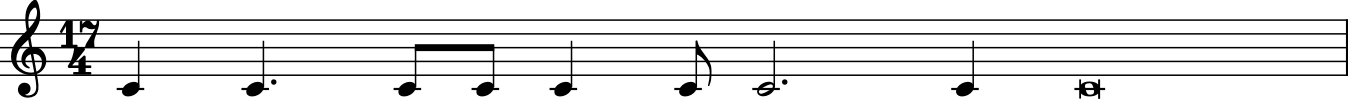

In [38]:
tree = Tree(root)
tree.apply([(split, dict(ratio=1/2, right_child_upbeat=1/4)),
            (split, dict(ratio=1/2, right_child_upbeat=1/8)),
            (split, dict(ratio=1/2, right_child_upbeat=1/8)),
            (prepare, {}),
            (freeze, {}),
            (freeze, {}),
            (prepare, {}),
            (freeze, {}),
            (split, dict(ratio=1/2, right_child_upbeat=1/8)),
            (freeze, {}),
            (shift, {})
           ])
print(tree)
tree.show()

<img src="img/bb06.png">

Fast-forward to the whole tree:

(0.25, 4, 0) [(0.25, 2.0, -0.25) [(0.25, 1.0, -0.125) [(0.25, 0.5, -0.125) [[0, 0.25, 0][0, 0.5, -0.125]] (0.125, 0.5, -0.125) [[0, 0.125, 0](0, 0.5, -0.125) [[0, 0.25, -0.125](0.125, 0.25, -0.125) [[0, 0.25, 0.0]] ] ] ] [0.125, 1.0, -0.25]] (0.25, 2.0, 0) [(0.25, 1.0, -0.125) [(0.25, 0.5, -0.125) [[0, 0.25, 0][0, 0.5, -0.125]] (0.125, 0.5, -0.125) [[0, 0.5, 0.0]] ] (0.125, 1.0, 0) [(0, 1.0, 0.125)] ] ] 


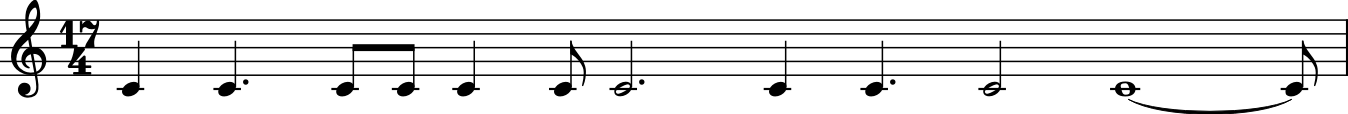

In [40]:
tree = Tree(root)
tree.apply([(split, dict(ratio=1/2, right_child_upbeat=1/4)),
            (split, dict(ratio=1/2, right_child_upbeat=1/8)),
            (split, dict(ratio=1/2, right_child_upbeat=1/8)),
            (prepare, {}),
            (freeze, {}),
            (freeze, {}),
            (prepare, {}),
            (freeze, {}),
            (split, dict(ratio=1/2, right_child_upbeat=1/8)),
            (freeze, {}),
            (shift, {}),
            (freeze, {}),
            (freeze, {}),
            (split, dict(ratio=1/2, right_child_upbeat=1/8)),
            (split, dict(ratio=1/2, right_child_upbeat=1/8)),
            (prepare, {}),
            (freeze, {}),
            (freeze, {}),
            (shift, {}),
            (freeze, {}),
            (shift, {}),
           ])
print(tree)
tree.show(playback=True)

<img src="img/bb07.png">

Overall, here is how all notes in the generated rhythm relate to each other in terms of generative steps: in yellow the splits, in blue the preparations, in green the anticipations. Orange boxes highlight places where some notes "steal time" from other notes (because of anticipations).

<img src="img/ColouredDerivation.png">